In [2]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

1)

In [3]:
tickers = ['ASML', 'SAN.PA', 'TTE', 'MC.PA', 'REP.MC', 'VOW3.DE', 'TIT.MI', 'AD.AS', 'MT.AS', 'SIE.DE']
market_index = '^STOXX'  # Indice di riferimento STOCK600

# Scaricare i dati mensili per gli ultimi 5 anni
start_date = "2020-03-01"
end_date = "2025-03-01"

data = yf.download(tickers + [market_index], start=start_date, end=end_date, interval='1mo')['Close']
data = data.dropna()

# Calcola i rendimenti mensili
returns = data.pct_change().dropna() * 100

# Tasso risk-free
rf = 0.0270 / 12

# Calcolo rendimenti in eccesso
excess_returns = returns - rf
market_excess_returns = excess_returns[market_index]

# Consideriamo solo le ultime 60 osservazioni (5 anni di dati mensili)
excess_returns = excess_returns.tail(60)
market_excess_returns = market_excess_returns.tail(60)

# Calcolo di beta e alfa
betas = {}
alfas = {}
significanza_alfa = {}
significanza_beta = {}
summary_stats = {}

for ticker in tickers:
    X = sm.add_constant(market_excess_returns)  # Aggiunge l'intercetta per calcolare alfa
    y = excess_returns[ticker]

    model = sm.OLS(y, X).fit()

    alfas[ticker] = model.params['const']  # Alfa è l'intercetta
    betas[ticker] = model.params[market_index]  # Beta è il coefficiente del mercato

    # Verifica significatività
    significanza_alfa[ticker] = model.pvalues['const'] < 0.05  # True se significativo al 5%
    significanza_beta[ticker] = model.pvalues[market_index] < 0.05  # True se significativo al 5%

    summary_stats[ticker] = model.summary()

# Stampa risultati
for ticker in tickers:
    print(f'Ticker: {ticker}, Alpha: {alfas[ticker]:.4f} (Significativo: {significanza_alfa[ticker]}), '
          f'Beta: {betas[ticker]:.4f} (Significativo: {significanza_beta[ticker]})')
    print(summary_stats[ticker])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed


Ticker: ASML, Alpha: 0.3299 (Significativo: False), Beta: 1.9676 (Significativo: True)
                            OLS Regression Results                            
Dep. Variable:                   ASML   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     67.00
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           3.38e-11
Time:                        14:00:22   Log-Likelihood:                -200.13
No. Observations:                  59   AIC:                             404.3
Df Residuals:                      57   BIC:                             408.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

2)

In [4]:
# Calcolo dei beta aggiustati con la tecnica di Blume
betas_adjusted = {}

for ticker in tickers:
    beta = betas[ticker]
    # Beta aggiustato con Blume
    beta_adjusted = (2/3) * beta + (1/3) * 1  # Supponiamo che la media storica di beta sia 1
    betas_adjusted[ticker] = beta_adjusted

for ticker in tickers:
    print(f'Ticker: {ticker}, Alpha: {alfas[ticker]:.4f}, Beta: {betas[ticker]:.4f}, Beta Aggiustato (Blume): {betas_adjusted[ticker]:.4f}')
    print(summary_stats[ticker])

Ticker: ASML, Alpha: 0.3299, Beta: 1.9676, Beta Aggiustato (Blume): 1.6450
                            OLS Regression Results                            
Dep. Variable:                   ASML   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     67.00
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           3.38e-11
Time:                        14:00:22   Log-Likelihood:                -200.13
No. Observations:                  59   AIC:                             404.3
Df Residuals:                      57   BIC:                             408.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

3)

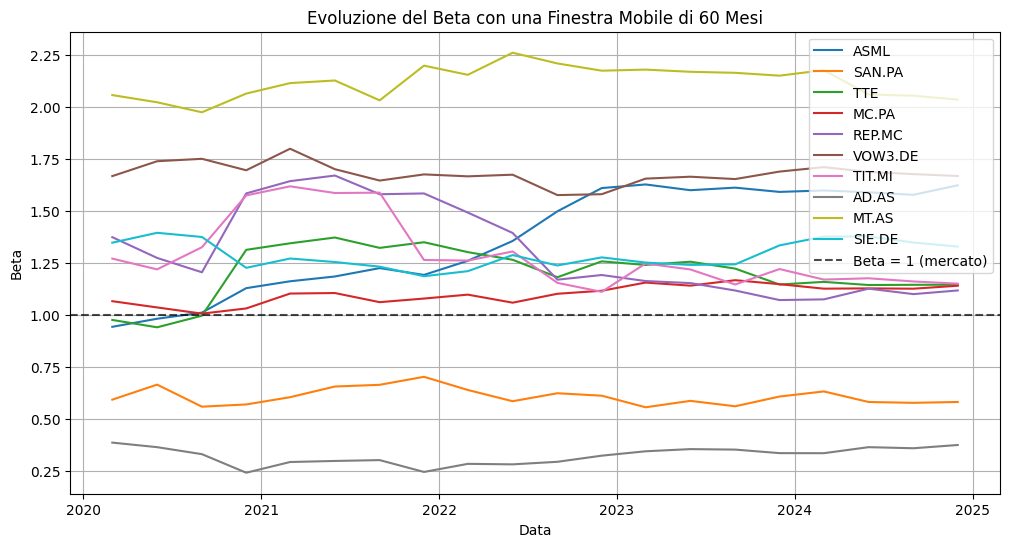

In [7]:
# Finestra mobile
window_size = 60
step = 3  # Spostamento di 3 mesi

rolling_betas = {ticker: [] for ticker in tickers}
rolling_dates = []

# Scorrere il dataset con una finestra mobile
for start in range(0, len(excess_returns) - window_size + 1, step):
    end = start + window_size
    rolling_dates.append(excess_returns.index[end - 1])

    market_window = market_excess_returns.iloc[start:end]

    for ticker in tickers:
        X = sm.add_constant(market_window)
        y = excess_returns[ticker].iloc[start:end]

        model = sm.OLS(y, X).fit()
        rolling_betas[ticker].append(model.params[market_index])

plt.figure(figsize=(12, 6))

for ticker in tickers:
    plt.plot(rolling_dates, rolling_betas[ticker], label=ticker)

plt.xlabel('Data')
plt.ylabel('Beta')
plt.title('Evoluzione del Beta con una Finestra Mobile di 60 Mesi')
plt.axhline(y=1, color='black', linestyle='--', alpha=0.7, label="Beta = 1 (mercato)")
plt.legend()
plt.grid(True)
plt.show()